# Import libraries

In [28]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import os
import logging

from itertools import combinations
from sklearn.metrics import mean_absolute_error

from catboost import CatBoostRegressor
from catboost import Pool

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/optiver-trading-at-the-close/public_timeseries_testing_util.py
/kaggle/input/optiver-trading-at-the-close/train.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/sample_submission.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv
/kaggle/input/optiver-trading-at-the-close/optiver2023/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/optiver-trading-at-the-close/optiver2023/__init__.py


# Loading the data

In [3]:
# Read the dataset from a CSV file using Pandas
df = pd.read_csv("/kaggle/input/optiver-trading-at-the-close/train.csv")

# Remove rows with missing values in the "target" column
df = df.dropna(subset=["target"])

# Reset the index of the DataFrame and apply the changes in place
df.reset_index(drop=True, inplace=True)

In [4]:
# Get the shape of the DataFrame (number of rows and columns)
print(df.shape)

(5237892, 17)


In [5]:
df.head(3)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2


In [6]:
df.dtypes

stock_id                     int64
date_id                      int64
seconds_in_bucket            int64
imbalance_size             float64
imbalance_buy_sell_flag      int64
reference_price            float64
matched_size               float64
far_price                  float64
near_price                 float64
bid_price                  float64
bid_size                   float64
ask_price                  float64
ask_size                   float64
wap                        float64
target                     float64
time_id                      int64
row_id                      object
dtype: object

# Optimizing the memory usage

The dataframe is not optimized, we can use less memory. We will take a method to do this.

Source: https://www.kaggle.com/code/verracodeguacas/fold-cv#%F0%9F%A7%B9-Importing-necessary-libra

In [7]:
# Function to reduce memory usage of a Pandas DataFrame
def reduce_mem_usage(df, verbose=1):
    """
    Iterate through all numeric columns of a dataframe and modify the data type
    to reduce memory usage.
    """
    
    # Calculate the initial memory usage of the DataFrame
    start_mem = df.memory_usage().sum() / 1024**2

    # Iterate through each column in the DataFrame
    for col in df.columns:
        col_type = df[col].dtype

        # Check if the column's data type is not 'object' (i.e., numeric)
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            # Check if the column's data type is an integer
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                # Check if the column's data type is a float
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)

    # Provide memory optimization information if 'verbose' is True
    if verbose:
        print(f"Memory usage of dataframe is {start_mem:.2f} MB")
        end_mem = df.memory_usage().sum() / 1024**2
        print(f"Memory usage after optimization is: {end_mem:.2f} MB")
        decrease = 100 * (start_mem - end_mem) / start_mem
        print(f"Decreased by {decrease:.2f}%")

    # Return the DataFrame with optimized memory usage
    return df

In [8]:
df = reduce_mem_usage(df, verbose=1)

Memory usage of dataframe is 679.35 MB
Memory usage after optimization is: 304.71 MB
Decreased by 55.15%


# Split the data on the train and the valid part

In [9]:
split_day = 430
df_train = df[df["date_id"] < split_day]
df_valid = df[df["date_id"] >= split_day]

In [10]:
not_features = ['row_id', 'time_id', 'target']
features = [col for col in df.columns if col not in not_features]
print(features)

['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag', 'reference_price', 'matched_size', 'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap']


In [38]:
df_train = df.dropna(subset=["target"])
df_train.reset_index(drop=True, inplace=True)

X = df_train[features].copy(deep=True)
y = df_train['target'].copy(deep=True)

In [39]:
len(X["date_id"].unique())

481

In [40]:
days = len(X.date_id.unique()) 
# There are 481 trading days, take the last n as testing
testing_days = 20
training_days = days - testing_days
training_days, testing_days

(461, 20)

In [41]:
# create mask for days
training_mask = X["date_id"] <= training_days
testing_mask = X["date_id"] > training_days

In [42]:
# subset and make training and validation sets
X_train, X_val, y_train, y_val = X[training_mask], X[testing_mask], y[training_mask], y[testing_mask]
#train_test_split(X, y, test_size=0.20, random_state=0, shuffle=True, stratify=X['stock_id']) # random_state=8
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((5028892, 14), (209000, 14), (5028892,), (209000,))

In [43]:
weights = [
    0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008,
    0.006, 0.002, 0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004,
    0.002, 0.002, 0.004, 0.002, 0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004,
    0.004, 0.004, 0.006, 0.002, 0.002, 0.04 , 0.002, 0.002, 0.004, 0.04 , 0.002, 0.001,
    0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002, 0.006, 0.004, 0.006, 0.004,
    0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004, 0.002, 0.004,
    0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
    0.02 , 0.004, 0.006, 0.002, 0.02 , 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02,
    0.006, 0.001, 0.002, 0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002,
    0.004, 0.006, 0.006, 0.001, 0.04 , 0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002,
    0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.004, 0.002, 0.006, 0.002,
    0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008, 0.006, 0.008, 0.002,
    0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001, 0.002,
    0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002,
    0.04 , 0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02 , 0.004, 0.002, 0.006, 0.02,
    0.001, 0.002, 0.006, 0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04,
    0.002, 0.008, 0.002, 0.004, 0.001, 0.004, 0.006, 0.004,
]

weights = {int(k):v for k,v in enumerate(weights)}

In [44]:
def feature_engineering(X):

    df = X.copy()

    # features engineering. source: https://www.kaggle.com/code/zulqarnainali/explained-singel-model-optiver
    df["liquidity_imbalance"] = df.eval("(bid_size - ask_size) / (bid_size + ask_size)")
    df["matched_imbalance"] = df.eval("(imbalance_size - matched_size) / (matched_size + imbalance_size)")
    df["price_spread"] = df["ask_price"] - df["bid_price"]
    df["market_urgency"] = df["price_spread"] * df["liquidity_imbalance"]
    
    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]

    # V1
    df["volume"] = df.eval("ask_size + bid_size")
    df["mid_price"] = df.eval("(ask_price + bid_price) / 2")
    df["size_imbalance"] = df.eval("bid_size / ask_size")
    
    for c in combinations(prices, 2):
        df[f"{c[0]}_{c[1]}_imb"] = df.eval(f"({c[0]} - {c[1]})/({c[0]} + {c[1]})")
        
    # V2
    df["stock_weights"] = df["stock_id"].map(weights)
    df["weighted_wap"] = df["stock_weights"] * df["wap"]
    df['wap_momentum'] = df.groupby('stock_id')['weighted_wap'].pct_change(periods=6)
    df["imbalance_momentum"] = df.groupby(['stock_id'])['imbalance_size'].diff(periods=1) / df['matched_size']
    df["price_spread"] = df["ask_price"] - df["bid_price"]
    df["spread_intensity"] = df.groupby(['stock_id'])['price_spread'].diff()
    df['price_pressure'] = df['imbalance_size'] * (df['ask_price'] - df['bid_price'])
    df['market_urgency'] = df['price_spread'] * df['liquidity_imbalance']
    df['depth_pressure'] = (df['ask_size'] - df['bid_size']) * (df['far_price'] - df['near_price'])
    df['spread_depth_ratio'] = (df['ask_price'] - df['bid_price']) / (df['bid_size'] + df['ask_size'])
    df['mid_price_movement'] = df['mid_price'].diff(periods=5).apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    df['micro_price'] = ((df['bid_price'] * df['ask_size']) + (df['ask_price'] * df['bid_size'])) / (df['bid_size'] + df['ask_size'])
    df['relative_spread'] = (df['ask_price'] - df['bid_price']) / df['wap']
    
    for func in ["mean", "std", "skew", "kurt"]:
        df[f"all_prices_{func}"] = df[prices].agg(func, axis=1)
        df[f"all_sizes_{func}"] = df[sizes].agg(func, axis=1)
        

# generate time & stock features
    df["dow"] = df["date_id"] % 5
    df["dom"] = df["date_id"] % 20
    df["seconds"] = df["seconds_in_bucket"] % 60
    df["minute"] = df["seconds_in_bucket"] // 60
    
    return df.drop(columns=["date_id"])

In [45]:
%%time 

# apply feature engineering
X_train = feature_engineering(X_train)
X_val = feature_engineering(X_val)

X_train.shape, X_val.shape

CPU times: user 24.9 s, sys: 5.12 s, total: 30 s
Wall time: 29.2 s


((5028892, 58), (209000, 58))

In [46]:
train_pool = Pool(data=X_train, label=y_train)
val_pool = Pool(data=X_val, label=y_val)

In [47]:
params = dict(
    loss_function="MAE",
    eval_metric="MAE",
    metric_period=100,
    bootstrap_type="Bernoulli",
    od_type="Iter",
    od_wait=20,
    border_count=32,
    task_type="CPU", # "GPU",
    random_seed=42,
    iterations=600,
    subsample=0.78,
    random_strength=11.285714149475098,
    depth=8,
    l2_leaf_reg=33,
    learning_rate=0.012
)


model = CatBoostRegressor(**params)

In [49]:
%%time

# https://medium.com/analytics-vidhya/catboost-101-fb2fdc3398f3
final_params = params.copy()
# updates = dict()
# final_params.update(updates)
# print(final_params)
final_model = CatBoostRegressor(**final_params)
final_model.fit(
    X_train,
    y_train,
    eval_set=(X_val, y_val)
)

print("-----Predicting with the reduced set model-----------")
y_val_pred = final_model.predict(X_val)
y_val_mae = mean_absolute_error(y_val, y_val_pred)
print(f"MAE on validation set: {y_val_mae:.4f}")

0:	learn: 6.4315488	test: 5.7799205	best: 5.7799205 (0)	total: 1.69s	remaining: 16m 51s
100:	learn: 6.3517203	test: 5.7257311	best: 5.7257311 (100)	total: 2m 52s	remaining: 14m 11s
200:	learn: 6.3323581	test: 5.7146558	best: 5.7146558 (200)	total: 5m 34s	remaining: 11m 4s
300:	learn: 6.3221662	test: 5.7080593	best: 5.7080593 (300)	total: 8m 15s	remaining: 8m 12s
400:	learn: 6.3156502	test: 5.7041239	best: 5.7041239 (400)	total: 10m 55s	remaining: 5m 25s
500:	learn: 6.3105895	test: 5.7009449	best: 5.7009449 (500)	total: 13m 38s	remaining: 2m 41s
599:	learn: 6.3067059	test: 5.6986503	best: 5.6986503 (599)	total: 16m 20s	remaining: 0us

bestTest = 5.69865026
bestIteration = 599

-----Predicting with the reduced set model-----------
MAE on validation set: 5.6987
CPU times: user 53min 28s, sys: 9.61 s, total: 53min 38s
Wall time: 16min 24s


In [21]:
for key,value in final_model.get_all_params().items():
    print('{}, {}'.format(key,value))

nan_mode, Min
eval_metric, MAE
iterations, 600
sampling_frequency, PerTree
leaf_estimation_method, Exact
od_pval, 0
random_score_type, NormalWithModelSizeDecrease
grow_policy, SymmetricTree
penalties_coefficient, 1
boosting_type, Plain
model_shrink_mode, Constant
feature_border_type, GreedyLogSum
bayesian_matrix_reg, 0.10000000149011612
eval_fraction, 0
force_unit_auto_pair_weights, False
l2_leaf_reg, 33
random_strength, 11.285714149475098
od_type, Iter
rsm, 1
boost_from_average, True
model_size_reg, 0.5
pool_metainfo_options, {'tags': {}}
subsample, 0.7799999713897705
use_best_model, True
od_wait, 20
random_seed, 42
depth, 8
posterior_sampling, False
border_count, 32
classes_count, 0
auto_class_weights, None
sparse_features_conflict_fraction, 0
leaf_estimation_backtracking, AnyImprovement
best_model_min_trees, 1
model_shrink_rate, 0
min_data_in_leaf, 1
loss_function, MAE
learning_rate, 0.012000000104308128
score_function, Cosine
task_type, CPU
leaf_estimation_iterations, 1
bootstrap_t

# Final predictions

In [50]:
import optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()

Exception: You can only call `make_env()` once.

In [51]:
for (test, revealed_targets, sample_prediction) in iter_test:
    X_test = test[features].copy(deep=True)
    X_test = feature_engineering(X_test)
    
    sample_prediction["target"] = final_model.predict(X_test)
    env.predict(sample_prediction)

array([[<Axes: title={'center': 'target'}>]], dtype=object)

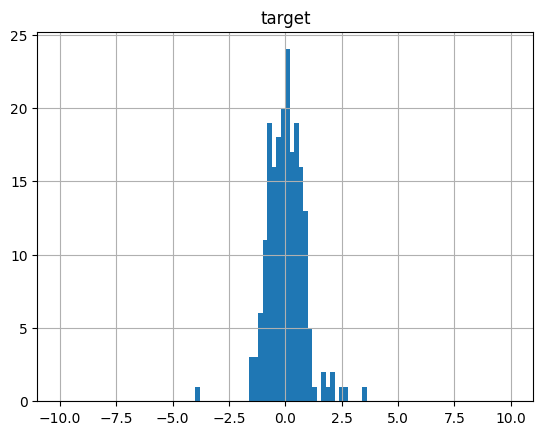

In [52]:
sample_prediction.hist(column='target', bins=100, range=[-10,10])

In [53]:
sample_prediction.to_csv('preds_more_features.csv')